# UC San Diego: Neural Data Science
## Classifying Sleep Based on Prior Working Memory Task Load

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Names

- Anjali Srinivasan
- Aaditya Prasad
- Joakim Nguyen
- Yohan Kim
- Kenton Guarian
- Mary Kovic

# Overview

In this project, we investigated whether it is possible to determine if an individual performed a high-load or low-load working memory task prior to sleep based on EEG data from their sleep. This analysis made use of the LISC database to determine what features of the EEG data would be the most applicable to working memory. After mining for relevant terms, we cleaned the data, extracted our features of interest, and performed k-means clustering. We then evaluated whether the clustering successfully separated the data by what working memory task the participant performed.

<a id='research_question'></a>
# Research Question

Can we predict whether a subject performed a high-load or low-load working memory task prior to sleeping based on EEG signals from that nap?

<a id='background'></a>

## Background & Prior Work

   After investigating the Nap EEG data, we became curious about whether we could use the scalp EEG signals to determine whether the participant performed a high-load or a low-load working memory task prior to sleeping. We knew from prior knowledge that sleep has a role in consolidating information and memories. Additionally, Ellenbogen et al (2006) demonstrated that sleep protects declarative memories and has a role in memory recall [1].
    
   Sleep deprivation can have an effect on cognitive function and performance - in Choo et al (2005), participants that were sleep deprived performed worse on the n-back working memory task than their rested counterparts [2]. Additionally, Gradisar et al (2016) observed that adolescents that are sleep deprived (less than 8 hours of sleep) or have a sufficient amount of sleep (greater than 9 hours) perform worse than adolescents with 8-9 hours of sleep on various working memory tasks [3]. The effect sleep has on working memory performance is clearly complex and nuanced.

   Looking at this data, it is clear that sleep can have a substantial effect on working memory task performance, and that the brain has a role in consolidating memories during sleep. Thus, we are curious about whether there is a significant difference in brain activity after performing a working memory task. Pugin et al (2015) found that after undergoing working memory training, participants had an increase of slow wave activity during sleep [4]. We are curious as to whether a difference exists in nap EEG recordings without training and are investigating whether the complexity of the working memory task has a noticeable effect on the nap EEG recordings.

References:
- 1) https://www.sciencedirect.com/science/article/pii/S0960982206016071
- 2) https://www.sciencedirect.com/science/article/pii/S1053811904007074?via%3Dihub
- 3) https://link.springer.com/article/10.1111/j.1479-8425.2008.00353.x
- 4) https://academic.oup.com/sleep/article/38/4/607/2416936

# Hypothesis


Our hypothesis is that there will be more activity in the brain during sleep after a high-load working memory task compared to a low-load working memory task. Thus, we predict that it is possible to accurately cluster the data by working memory task load.

# Dataset(s)

LISC
- Link to the dataset: https://lisc-tools.github.io/lisc/auto_tutorials/index.html
- Number of observations: all scientific literature
LISC is a tool that allows users to perform text mining on scientific articles and various analyses. Users can query databases for terms of interest and learn how many articles contain those terms.

Nap EEG
- Link to the dataset: https://osf.io/chav7/
- Number of observations: 64-channel continuously scalped EEG data for 19 participants over 36 datasets

To combine these datasets, we will be utilizing LISC to find important terms that co-occur between sleep and working memory. We will then attempt to use these terms to determine which features to extract from the data when performing clustering analysis.

In [1]:
# making necessary directories
!mkdir original_eeg
!mkdir cleaned_eeg
!mkdir spindle_files
!mkdir lisc_analysis
!mkdir extracted_features

A subdirectory or file original_eeg already exists.
A subdirectory or file cleaned_eeg already exists.
A subdirectory or file spindle_files already exists.
A subdirectory or file lisc_analysis already exists.
A subdirectory or file extracted_features already exists.


In [2]:
# imports
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
import copy
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne

from bs4 import BeautifulSoup
from lisc import Counts
from lisc.utils.db import SCDB, create_file_structure
from lisc.utils.io import save_object
from lisc.plts.counts import plot_matrix
from wordcloud import WordCloud, get_single_color_func # WARNING: wordcloud REQUIRES Microsoft Visual C++ 14.0

# Local imports
from terminology import waves, eeg_features_2, additional_features
from utils.lisc import run_and_save, load_counts, pick_top

import sklearn
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Data Wrangling

## Raw EEG Data

Our first step is to retrieve the EEG data. To do this, we will need to use the download links provided in the file 'available_subjects.csv' (provided in the current working directory) to retrieve the eeg data.

Note for available_subjects.csv:
This file was originally retreived from the github page for the original paper.
Link to github: https://github.com/nmningmei/Get_Sleep_data
However, there were multiple cells in this file that had typos and naming errors - we edited these errors manually. The `available_subjects.csv` file provided with this project is the fixed version of the one from the original github.

The eeg data will be saved in the `original_eeg` directory.

Samples with `l2` in the name are recordings taken after a low-load working memory task. Samples with `l5` in the name are recordings taken after a high-load working memory task.

In [8]:
subjects_df = pd.read_csv('available_subjects.csv')

for link in subjects_df['link']:
    link = link.strip()
    !wget -q -P original_eeg/ {link}
    
# store all vhdr filenames to iterate through for cleaning
vhdrs = [name for name in subjects_df['name'] if name.endswith('.vhdr')]

## Annotation files

Next, we are going to retreive the annotation data. We will be using this data in exploratory analyses and will attempt to use these labels to classify the data. These annotations were manually marked by experts for each subject in this dataset.

The spindle annotation data will be saved in the `spindle_files` directory.

In [6]:
for file_name,link in zip(subjects_df['annotation_file_name'],subjects_df['annotation_file_link']):
    save_file_name = "./spindle_files/" + file_name
    !wget -q -O {save_file_name} {link}

^C


# Data Cleaning

Next, we need to clean the eeg data.

While exploring the dataset, we noticed a discrepancy between the code provided in the github (link provided in the 'Data Wrangling' section) and the code provided in the original dataset (link provided in the dataset information section). The code provided in the original dataset filtered the data using a bandpass filter, ran it through a notch filter, and performed ICA (independent component analysis) on it.

In contrast, the code on the github did not run the samples through ICA. We weren't sure which to follow - if ICA was not necessary we did not want to run it, as it is a computationally intensive algorithm that takes some time to run,

To clarify whether we should run each sample through ica, we contacted Ning Mei, one of the authors on the paper published with the dataset. Mei informed us that ICA has little to no effect on the data from this dataset, so it is not worth the time to run it.

In [41]:
def raw_import(signal_str):
    # read in raw eeg file and set channel types
    raw = mne.io.read_raw_brainvision(signal_str, preload=True)
    
    # Set channel type as said in original research paper
    channel_types = {'LOc':'eog','ROc':'eog','Aux1':'misc'}
    raw.set_channel_types(channel_types, verbose=False) # Set channel type as said in original research paper
    
    
    raw_ref ,_  = mne.set_eeg_reference(raw, ref_channels='average', projection=True, verbose=False)
    raw_ref.apply_proj(verbose=False) # it might tell you it already has been re-referenced, but do it anyway

    # read standard montage - montage is important for visualization
    raw.set_montage('standard_1020', verbose=False)
    
    # # print some information about the data
    # print(raw.info)
    
    # # The graph's voltage is microvolt, but actually it should be in volts, so we convert that
    # scalingDict=dict(mag=1e-12, grad=4e-11, eeg=20e-6, eog=150e-6, ecg=5e-4, emg=1e-3, ref_meg=1e-12,
    #                  misc=1e-3, stim=1, resp=1, chpi=1e-4)
    
    # # plot the first 10 seconds of the data and reload it
    # # comment out the line below to reduce amount of output when running data cleaning
    # raw.plot(start=0., duration = 10.0, n_channels=20, scalings = scalingDict)
    
    return raw

The function **raw_import** takes filename as an input. What the function is doing is that first, it reads EEG signal. Then, it re-assign some channels that we are going to use into correct format (for example, LOc to eog). Then, we define **montage**. **Montage** is MNE's predefined Electrode location setting. It is crucial to set montage to the raw object, since montage is used for Machine Learning algorithms such as ICA. For our dataset, we set it as **Standard_1020** (as said in original paper). Lastly, we convert voltage type from microvolt to volt, to not confuse when reading dataset. 

In [42]:
def filter_channels(raw):
    
    # create list of channels to retain in raw
    chan_list=raw.ch_names[:-2]# exclude 'AUX','STIM' channels
    if 'LOc' not in chan_list:
        chan_list.append('LOc')
    if 'ROc' not in chan_list:
        chan_list.append('ROc')
    
    # pick useful channels to use; which means to remove unnecessary channels like AUX
    raw.pick_channels(chan_list)
    raw.set_channel_types({'LOc':'eog','ROc':'eog'}, verbose=False)
    raw.pick_channels(chan_list)
    
    # pick channels by type (eeg)
    picks = mne.pick_types(raw.info,meg=False,eeg=True,eog=False,stim=False) # Only use eeg
    
    # band-pass filter the data so that all signal fits between low frequency of 200 and
    # high frequency of 1
    raw.filter(l_freq=200, h_freq=1,l_trans_bandwidth=0.01, h_trans_bandwidth='auto', filter_length='auto',
               picks=picks, verbose=False)
    noise_cov = mne.compute_raw_covariance(raw.set_eeg_reference(), picks=picks, verbose=False)
    
    # apply notch filter(from 60 to 240, with interval of 60)
    raw.notch_filter(np.arange(60,241,60), picks=picks, verbose=False)
    return picks, noise_cov

The function **filter_channels** takes raw as an input. We first remove some irrelevant channels like **AUX**. Then, for all non-usual channels (e.g. LOc), we consider them as eog (artifact events). Then, we exclude non-eeg signals. Finally, we move onto filtering. First, we run Band-pass filtger with low frequency of **1 Hz** and high frequency of **200 Hz**. We chose those frequencies because it is common to exlude outside those region. Then, we run **notch filter** for intervals of **60Hz, 120Hz, 180Hz, and 240Hz (already excluded)**. The reason is because in North American Region, we use Alternating Current (AC), which electrical current periodically sends full electricity to the machien to operate, and that frequency is in 60 Hz, thus we remove those region. Lastly, since our filtering is done, we return the filtered-signal for us to use.

In [43]:
def save_cleaned_result(clean_raw, signal_str):

    # save cleaned eeg files as .fif into the cleaned_eeg directory
    save_dir = "./cleaned_eeg/"
    
    # Note: you will get a warning that the name of the .fif file we are creating does not follow naming
    # conventions. This warning can be ignored; it does not affect the rest of the analysis.
    savename=signal_str[:len(signal_str)-5:] + '.fif'
    clean_raw.save(save_dir + savename, # file name
               buffer_size_sec=None, # size of data chunks in seconds. 
               proj=False, # always false
               overwrite = False, # Default to "false" so you don't mess up
    )

Finally, we bring up all raw signal files and process the filtering. Since Jupyter Notebook needs to run all cells when its kernel restarts, we decided to save the filtered file so that we don't need to run the filtering part again.

In [44]:
# iterate through each eeg sample
for vhdr in vhdrs:
    signal_str = "./original_eeg/" + vhdr # Path to Signal
    
    # import raw data
    raw = raw_import(signal_str)
    
    # filter data
    picks, noise_cov = filter_channels(raw)
    
    # save cleaned data as a .fif file
    save_cleaned_result(raw, vhdr)

Extracting parameters from ./original_eeg/suj11_l5nap_day1.vhdr...
Setting channel info structure...
Reading 0 ... 1858749  =      0.000 ...  1858.749 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.
Extracting parameters from ./original_eeg/suj11_l2nap_day2.vhdr...
Setting channel info structure...
Reading 0 ... 1806049  =      0.000 ...  1806.049 secs...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Removing existing average EEG reference projection.


KeyboardInterrupt: 

# Data Visualization

## Checking the Data Cleaning

Now that our data is cleaned, let's take a look at it from before and after filtering. We'll use the file `suj11_l2nap_day2` as our example. The data we are about to visualize is Subject 11's nap following a low-load working memory task.

Extracting parameters from original_eeg/suj11_l2nap_day2.vhdr...
Setting channel info structure...
Reading 0 ... 1806049  =      0.000 ...  1806.049 secs...
Using matplotlib as 2D backend.


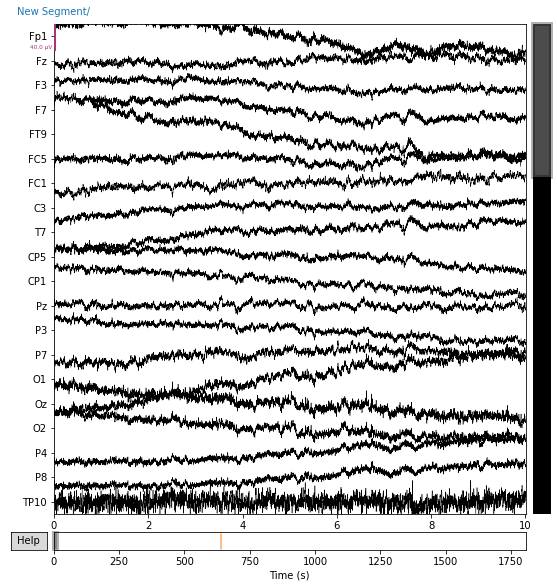

<RawBrainVision | suj11_l2nap_day2.eeg, 64 x 1806050 (1806.0 s), ~882.0 MB, data loaded>

In [45]:
# first, plot the prefiltered data and display basic information
raw = raw_import("original_eeg/suj11_l2nap_day2.vhdr")
raw.plot()
raw

In [46]:
# now, let's look at the filtered data
clean_raw = mne.io.read_raw_fif("cleaned_eeg/suj11_l2nap_day2.fif")
clean_raw.plot()
clean_raw

Opening raw data file cleaned_eeg/suj11_l2nap_day2.fif...


<ipython-input-46-26506c10643a>:2: RuntimeWarning: This filename (cleaned_eeg/suj11_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  clean_raw = mne.io.read_raw_fif("cleaned_eeg/suj11_l2nap_day2.fif")


FileNotFoundError: fname does not exist: c:\Users\khngu\Documents\GitHub\Predict-Sleep-EEG\final_notebook\cleaned_eeg\suj11_l2nap_day2.fif

As we can see, the filtering has removed much of the noise present in our data. Great! Now we're able to perform some analysis and extract relevant features from the data.

## LISC: What are the relevant features?

However, first, we must ask the question "What features do we extract?" To answer this, let's take a small break from the Nap EEG data and turn our attention towards LISC. When starting this project, we were unsure of what terms were related between sleep and working memory. Using LISC, we were able to narrow down possible terms to look at in our classification analysis.

In [12]:
def run_and_save(counts, filename:str, db):
    '''Executes run_collection() on Counts object and saves it to SCDB (database).'''
    # Run co-occurrences of search terms.
    counts.run_collection()

    # Save the data to SCDB.
    db_dir = os.path.join('lisc_analysis/', db.get_folder_path('counts'))
    save_object(counts, filename, directory=db_dir)

In [15]:
def load_counts(filename:str, db):
    '''Returns Counts object from SCDB (database).'''
    data_rpath = db.get_file_path('counts', filename)
    data_abspath = os.path.join('lisc_analysis/', data_rpath)
    return pd.read_pickle(data_abspath)

In [6]:
def pick_top(counts, top_n:int=None, thresh:float=None) -> list[tuple]:
    '''Returns the top 'n' co-occurrence or top percentile co-occurrences terms'''
    counts = copy.deepcopy(counts)
    len_A = len(counts.terms['A'].terms)
    len_B = len(counts.terms['B'].terms)

    top = []
    if top_n:
        thresh = 0

    assert 0 < thresh < 1, "Argument 'thresh' must be float between 0 and 1."

    # Weed out scores that are below certain threshold
    for i in range(len_A):
        for j in range(len_B):
            if counts.score[i][j] > counts.score.max() * thresh:
                top.append([counts.terms['A'].terms[i][0], counts.terms['B'].terms[j][0], counts.score[i][j]])

    top = sorted(top, key=lambda x: x[2], reverse=True)
    if top_n:
        top = top[:top_n]
    return top

In [3]:
# Initialize LISC SCDB (database) object and file structure.
create_file_structure("lisc_analysis")
db = SCDB('lisc_db')
db.gen_paths()

First, let's look more closely at terms associated with working memory in literature. To do this, we will be making use of terms from the Cognitive Atlas - https://www.cognitiveatlas.org/

In [8]:
url = "https://www.cognitiveatlas.org/concepts/categories/all"
page = requests.get(url)
data = page.text
soup = BeautifulSoup(data, 'html.parser')

# Let's cut down html into the categories of concepts
page_content = soup.find('div', id='pagecontent')
categories = page_content.find_all('h3')
categories = list(enumerate([category.get_text() for category in categories]))
categories

[(0, 'Classified under Action'),
 (1, 'Classified under Attention'),
 (2, 'Classified under Emotion'),
 (3, 'Classified under Executive/Cognitive Control'),
 (4, 'Classified under Language'),
 (5, 'Classified under Learning and Memory'),
 (6, 'Classified under Motivation'),
 (7, 'Classified under Perception'),
 (8, 'Classified under Reasoning and Decision Making'),
 (9, 'Classified under Social Function')]

As we can observe from the output above, there are many categories in the Cognitive Atlas that can be associated with working memory. The research mentioned in the introduction section of this notebook primarily focuses on sleep related to memory consolidation. Thus, we will be primarily focusing on the 'Learning and Memory' category.

In [9]:
# Select which category by index
category_idx = 5

# Obtain all the concept terms in the category you chose
category = soup.find(string=categories[category_idx][1]).parent
concepts = category.find_next_sibling('div').find_all('a')
concepts = [term.get_text() for term in concepts]

# Remove some words that aren't productive in "concepts".
remove = ['memory', 'skill', 'learning', 'knowledge']
concepts = [concept for concept in concepts if concept not in remove]

In [10]:
# Run co-occurances of "working memory" to the concepts
terms_a = ["working memory"]
terms_b = sorted(concepts) # alphabetical order

counts = Counts()
counts.add_terms(terms_a, dim='A')
counts.add_terms(terms_b, dim='B')

Note: the `.p` files created by `run_and_save()` are included in the lisc_analysis directory. Because running this function can take a very long time, we recommend commenting out the `run_and_save()` calls when rerunning this notebook and just loading the files we provided.

In [13]:
# Run and save co-occurrence data
run_and_save(counts, 'wm-memlrn.p', db)

In [7]:
# Load the counts data and compute its scores
pickle1 = load_counts('wm-memlrn.p', db)
pickle1.compute_score('normalize', dim='A')

# Prepare a wordcloud       
# LISC's wordcloud function won't suffice so we'll do it ourselves.
###################################################################

# Compile the words and frequencies into a dictionary to pass into the WordCloud object.
# Conveniently, our data is already 1D.
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
# Tweak the parameters to produce a beautiful wordcloud.
wc = WordCloud(width=2560, height=1440, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

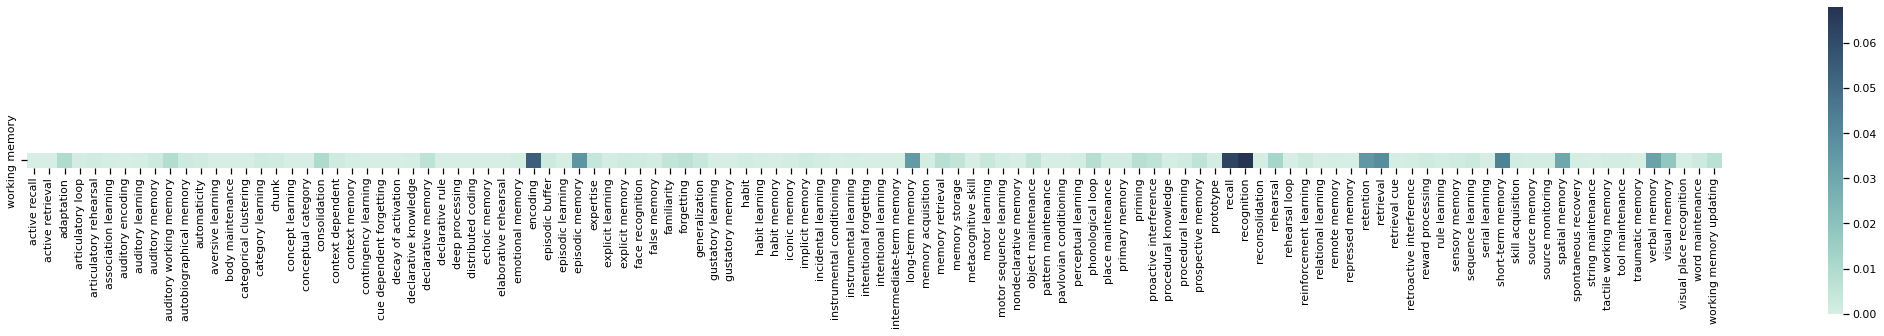

In [8]:
plot_matrix(pickle1, attribute='score', cmap='blue', figsize=(30, 5), square=True) # kwargs sent to seaborn

(-0.5, 2559.5, 1439.5, -0.5)

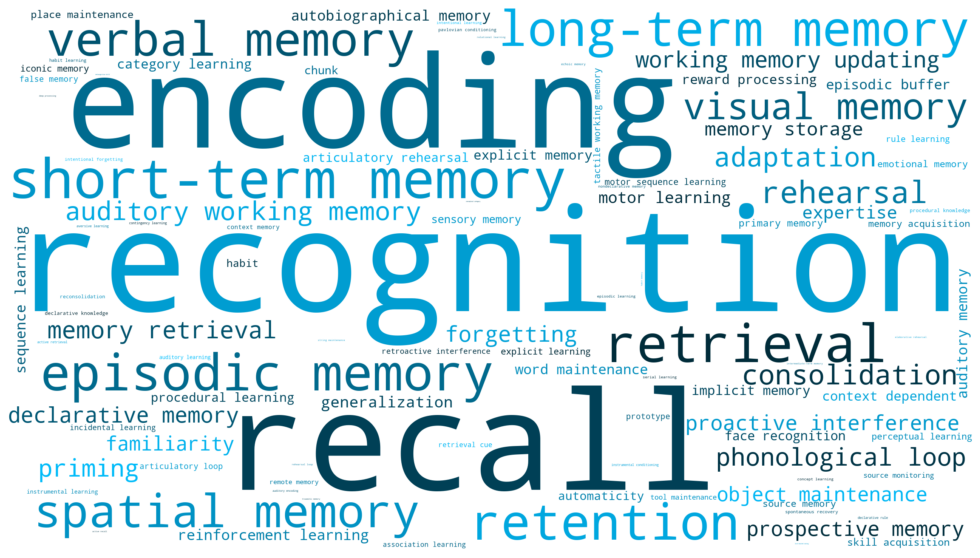

In [9]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

This word cloud represents the most common learning and memory terms that co-occur with working memory. Looking at the word cloud, we can see that the most common learning and memory terms that co-occur with working memory are 'recognition', 'recall', and 'encoding'. However, this doesn't give us much insight into possible features to extract or things to look for in the EEG data.

Let's investigate what terms co-occur between 'learning and memory' and 'EEG features' to see if we can gain more insight.

In [23]:
# Prepare new Counts object
terms_c = sorted(concepts)
terms_d = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_d.remove('slow wave') # Broad term

counts2 = Counts()
counts2.add_terms(terms_c, dim='A')
counts2.add_terms(terms_d, dim='B')

In [24]:
# Run and save co-occurrence data
run_and_save(counts2, 'memlrn-eeg.p', db)

C:\Users\khngu\AppData\Roaming\Python\Python39\site-packages\lisc\analysis\counts.py:48: RuntimeWarning: divide by zero encountered in true_divide
  out = data / counts_2d
C:\Users\khngu\AppData\Roaming\Python\Python39\site-packages\lisc\analysis\counts.py:48: RuntimeWarning: invalid value encountered in true_divide
  out = data / counts_2d


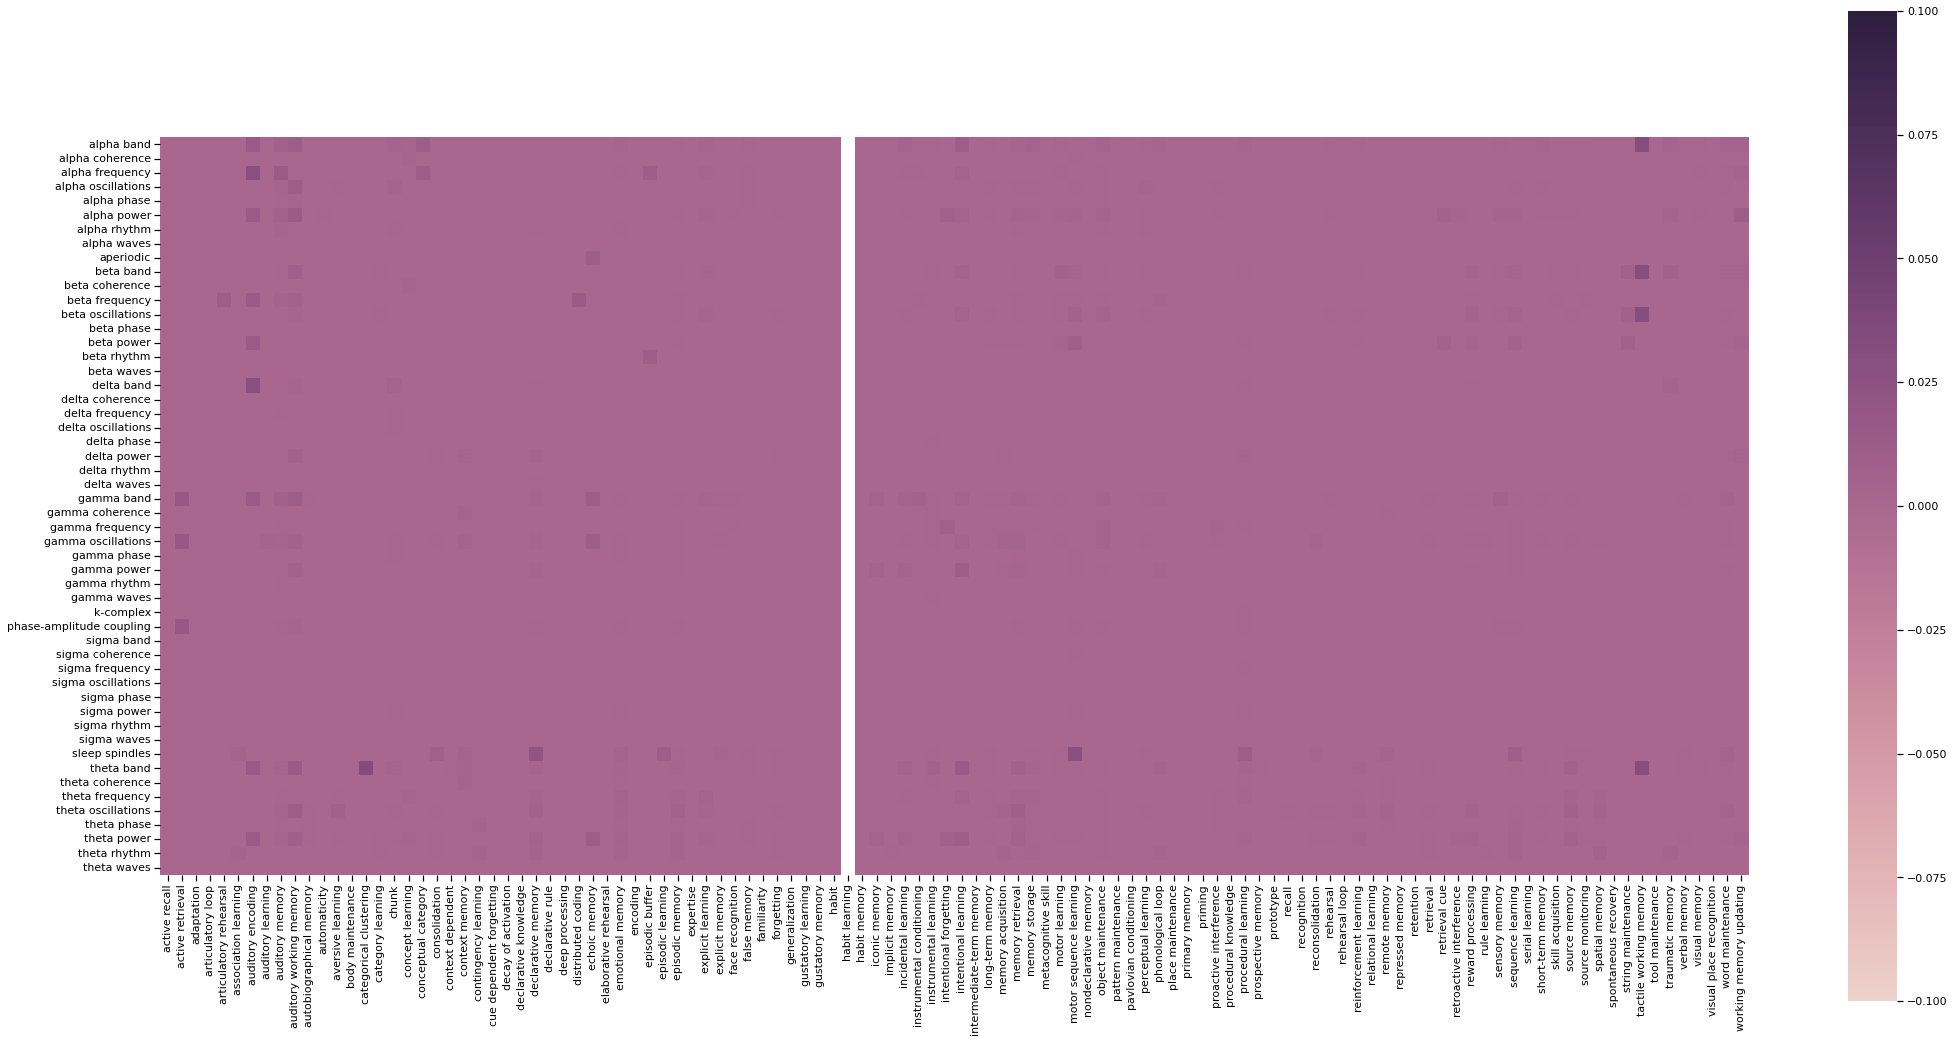

In [10]:
# Load the counts data and compute its scores
pickle2 = load_counts('memlrn-eeg.p', db)
pickle2.compute_score('normalize', dim='A')
plot_matrix(pickle2, attribute='score', transpose=True, figsize=(30, 15), square=True)

This matrix has way too many terms, and it looks like there aren't too many co-occurences. Let's narrow down our search a bit and find co-occurences between 'working memory' exclusively and 'EEG features'.

In [26]:
# Prepare another wordcloud with "working memory" terms.
# Here, the top 12 words are selected.
Dict = {}
for word, score in zip(pickle1.terms['B'].terms, pickle1.score[0]):
    Dict[word[0]] = score
wc = WordCloud(width=2560, height=1440, max_words=12, background_color='white').fit_words(Dict)
color_func1 = get_single_color_func('deepskyblue')

(-0.5, 2559.5, 1439.5, -0.5)

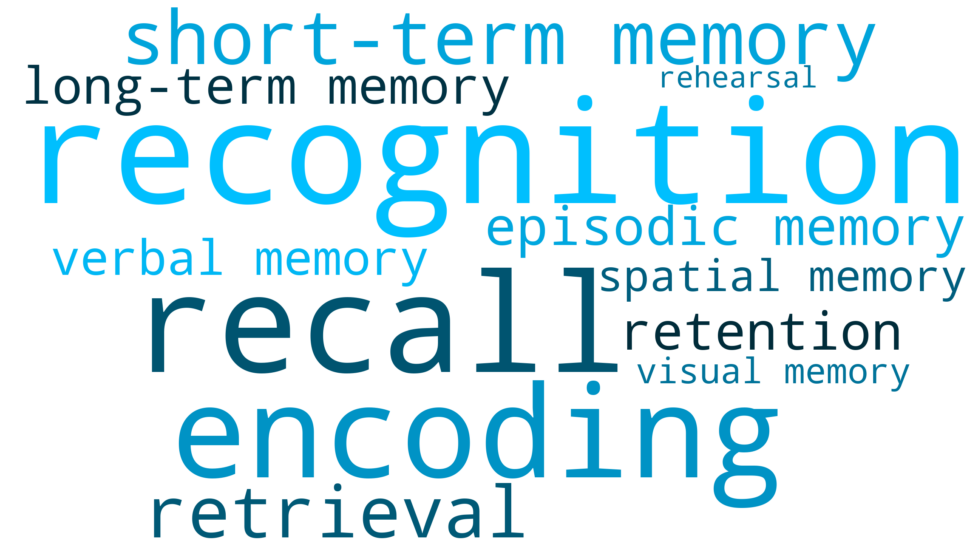

In [27]:
plt.figure(figsize=(18,10))
plt.imshow(wc.recolor(color_func=color_func1), interpolation='bilinear')
plt.axis('off')

The common terms here appear to be similar to the working memory terms - the most prevalent terms appear to be 'recognition', 'recall', and 'encoding'. However, this still doesn't give us enough information about what features are useful. Let's look more specifically at 'working memory' rather than 'learning and memory' with the EEG terms.

In [28]:
# Prepare new Counts object
terms_e = list(zip(*pick_top(pickle1, top_n=12)))[1]
terms_f = sorted([wave + ' ' + feature for wave in waves for feature in eeg_features_2] + additional_features)
terms_f.remove('slow wave') # Broad term

counts3 = Counts()
counts3.add_terms(terms_e, dim='A')
counts3.add_terms(terms_f, dim='B')

In [30]:
# Run and save co-occurrence data
run_and_save(counts3, "wm-eeg.p")

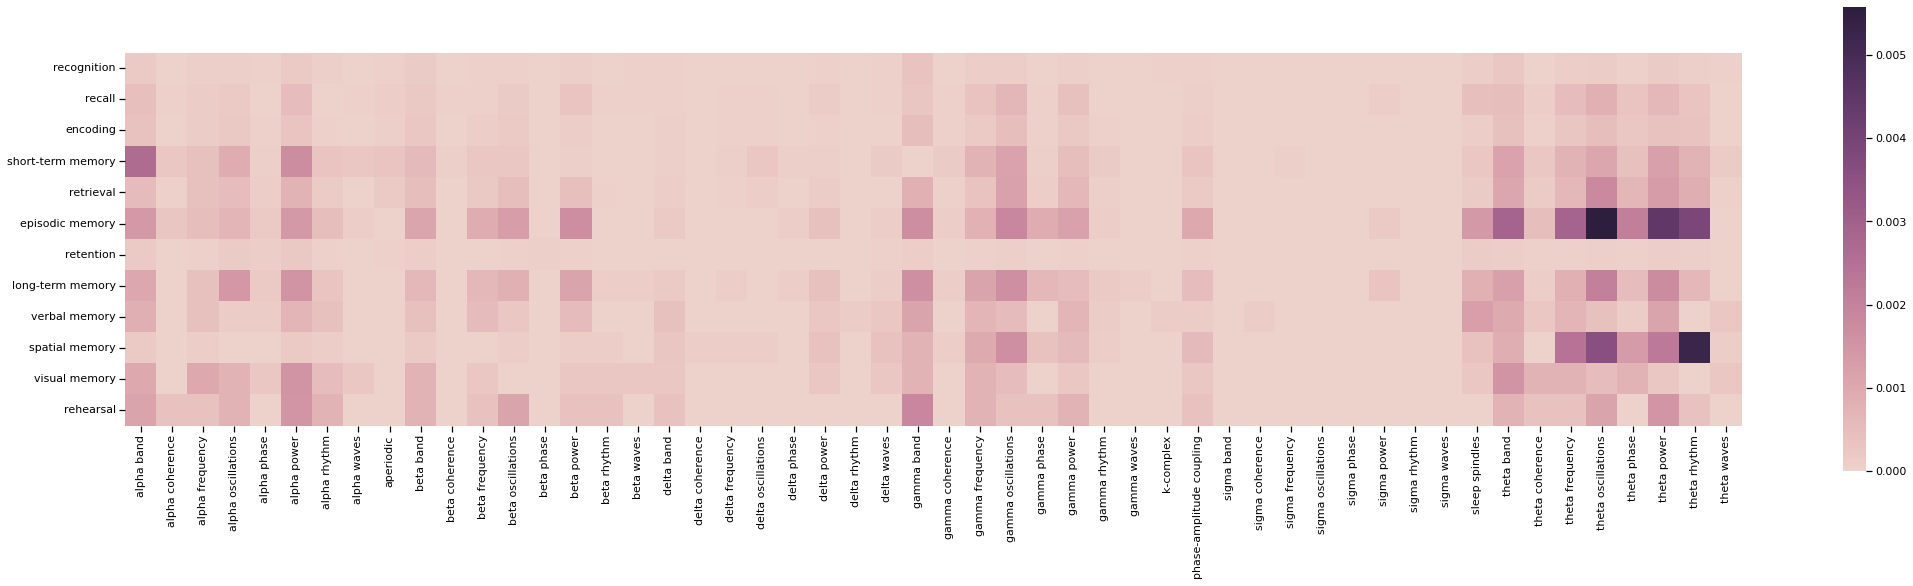

In [12]:
# Load the counts data and compute its scores
pickle3 = load_counts('wm-eeg.p', db)
pickle3.compute_score('normalize', dim='A')
plot_matrix(pickle3, attribute='score', cmap='purple', figsize=(30, 8), square=True)

As we can see, many of these working memory terms have co-occurences with different types of oscillations and waves. In sleep, each of these types of waves corresponds to a frequency range of scalp recordings. Seeing as how working memory seems to have a lot to do with different wavelengths and frequencies of brain activity, it is clear that extracting frequency data from each sample is a promising method to classifying our data.

To do this, we'll need to determine the power spectrum of the data. This will give us distribution of the signal power over frequencies, which will demonstrate which frequencies were most represented in the EEG data.

Let's look at the power spectrum for the data we visualized earlier:

Effective window size : 2.048 (s)


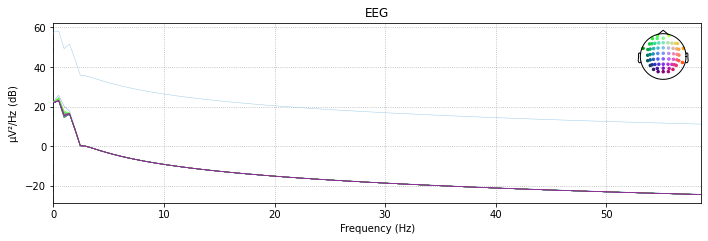

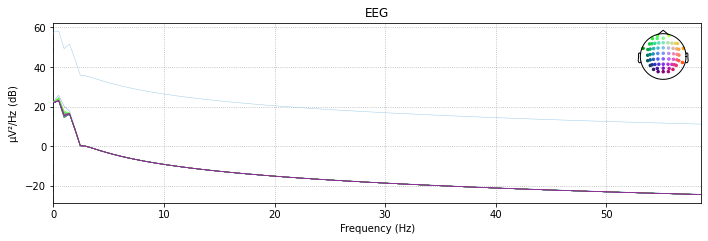

In [32]:
clean_raw.plot_psd(fmax=59)

What we see here is consistent with the results of the text mining. The EEG data for this sample can be broken down into different waves of various frequencies. Each channel has its own curve, so we need to be conscious of that when extracting features. If working memory activity affects levels of brain activity, it should be visible in the power spectrum for the data.

# Data Analysis & Results

Now that we know what we're looking for, let's extract the power spectrum from each datapoint. We'll be using `available_subjects.csv` to iterate through the data.

In [33]:
def import_data(eeg_file, crop=True):
    
    # read in cleaned eeg file and crop it to a maximum of 30 minutes
    raw = mne.io.read_raw_fif(eeg_file, preload=True)
    
    # if crop is true, crop data to 1800 seconds
    if crop:
        raw.crop(tmax=1800)
    
    return raw

In order to look at the events in the annotation file, we need to epoch the data. Epochs allow us to look at discontinuous segments of data of equal length. This is ideal when attempting to classify by looking at the annotations; we are concerned simply with the annotations and not the data as a whole.

When epoching the data, we had to decide how to form the epochs and what events to use from the annotation file. Initially, we considered using all annotations to epoch. However, after doing some research we learned that sleep spindles have a major role in memory consolidation. Thus, we decided to only epoch the data where a spindle annotation is present in the annotation file.
- Source: https://www.cell.com/current-biology/pdf/S0960-9822(18)30375-0.pdf

In [34]:
def epoch_data(data, spindle_file):
    
    # read annotation file
    events = pd.read_csv(spindle_file)
    annotation_events = events[events['Annotation'] == 'spindle']
    event_array = np.vstack([annotation_events['Onset'].values, [0] * annotation_events.shape[0],
                             [1] * annotation_events.shape[0]]).T.astype(int)
    
    epochs = mne.Epochs(raw, events = event_array, event_id = {'spindle':1}, tmin = -0.5, 
                        tmax = 1.5, baseline = (-0.5,-0.2), preload = True, picks = picks, detrend = 1)
    
    return epochs

In [35]:
def extract_power_series(data):
    
    # run psd_welch on each dataset
    # note: dimensions of returned matrix change depending on whether psd_welch is run on epoched data
    pxx, fx = mne.time_frequency.psd_welch(data, fmin= 1., fmax = 50, n_fft=1000, n_overlap = 500)
    
    return pxx, fx

In [36]:
eegs = np.array(subjects_df[subjects_df['name'].str.endswith('.eeg')]['name'])
eeg_file_names = [eegs[i].split('.')[0] + '.fif' for i in range(len(eegs))]
spindle_annotation_file_names = np.unique(np.array(subjects_df['annotation_file_name']))

In [40]:
eeg_file_dir = './cleaned_eeg/'
annotation_file_dir = './spindle_files/'
extracted_features_file_dir = './extracted_features/'

# skip files in 'skip' list - the signal appears to have been corrupted and cannot be passed
# to function extract_power_series() without throwing an error
skip = ['suj27_l5nap_day1.fif']

## Classification based on timepoints of spindle annotations

Let's try extracting features from the data at spindle locations.

In [43]:
power_series = []
fxs = []
labels = []

for eeg_file_name, spindle_annotation_file_name in zip(eeg_file_names, spindle_annotation_file_names):
    
    if eeg_file_name in skip:
        continue
        
    # adding our labels to the data - this will allow us to evaluate the accuracy of the clustering    
    if 'l2' in eeg_file_name:      # annotate with '0' if low-load
        labels.append(0)
    else:                          # annotate with '1' if low-load
        labels.append(1)
    
    full_eeg_path = eeg_file_dir + eeg_file_name
    full_spindle_annotation_path = annotation_file_dir + spindle_annotation_file_name
    
    # extract features from data epoched by spindle and epoch data by spindles
    # Because spindle events can occur beyond the 30 minutes in this data, we aren't going to crop it
    raw = import_data(full_eeg_path, crop=False)
    epochs = epoch_data(raw, full_spindle_annotation_path)
    
    # extract power series
    # because we are passing in an instance of mne.Epochs, psds will be an array of shape
    # (num_epochs, num_channels, num_frequencies)
    # fx will have shape (num_frequencies)
    psds, fx = extract_power_series(epochs)
    
    # Because each subject may have a different number of spindle annotations (and thus a different
    # number of epochs), we need to overage over epochs so we end up with a rectangular matrix
    # for clustering
    power_series.append(np.mean(psds,axis=0))
    fxs.append(fx)
    

power_series = np.stack(power_series)
fxs = np.stack(fxs)
labels = np.array(labels)

# save these values as a numpy zip for easy access in the future
np.savez_compressed(extracted_features_file_dir + 'spindle_extracted_features.npz', psd=power_series,
                    freqs=fxs,label=labels)

Opening raw data file ./cleaned_eeg/suj11_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj11_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1858749 =      0.000 ...  1858.749 secs
Ready.
Reading 0 ... 1858749  =      0.000 ...  1858.749 secs...
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 2001 original time points ...
3 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj11_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj11_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806049 =      0.000 ...  1806.049 secs
Ready.
Reading 0 ... 1806049  =      0.000 ...  1806.049 secs...
Not setting metadata
Not setting metadata
76 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 76 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj12_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj12_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1810549 =      0.000 ...  1810.549 secs
Ready.
Reading 0 ... 1810549  =      0.000 ...  1810.549 secs...
Not setting metadata
Not setting metadata
2 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 2 events and 2001 original time points ...
1 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj12_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj12_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806899 =      0.000 ...  1806.899 secs
Ready.
Reading 0 ... 1806899  =      0.000 ...  1806.899 secs...
Not setting metadata
Not setting metadata
88 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 88 events and 2001 original time points ...
7 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj13_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj13_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802149 =      0.000 ...  1802.149 secs
Ready.
Reading 0 ... 1802149  =      0.000 ...  1802.149 secs...
Not setting metadata
Not setting metadata
101 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 101 events and 2001 original time points ...
1 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj13_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj13_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805099 =      0.000 ...  1805.099 secs
Ready.
Reading 0 ... 1805099  =      0.000 ...  1805.099 secs...
Not setting metadata
Not setting metadata
49 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 49 events and 2001 original time points ...
3 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj14_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj14_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803449 =      0.000 ...  1803.449 secs
Ready.
Reading 0 ... 1803449  =      0.000 ...  1803.449 secs...
Not setting metadata
Not setting metadata
89 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 89 events and 2001 original time points ...
9 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj15_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj15_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802649 =      0.000 ...  1802.649 secs
Ready.
Reading 0 ... 1802649  =      0.000 ...  1802.649 secs...
Not setting metadata
Not setting metadata
59 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 59 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/Suj15_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/Suj15_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805349 =      0.000 ...  1805.349 secs
Ready.
Reading 0 ... 1805349  =      0.000 ...  1805.349 secs...
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 2001 original time points ...
1 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj16_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj16_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805999 =      0.000 ...  1805.999 secs
Ready.
Reading 0 ... 1805999  =      0.000 ...  1805.999 secs...
Not setting metadata
Not setting metadata
45 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 45 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj16_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj16_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806399 =      0.000 ...  1806.399 secs
Ready.
Reading 0 ... 1806399  =      0.000 ...  1806.399 secs...
Not setting metadata
Not setting metadata
72 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 72 events and 2001 original time points ...
4 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj17_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj17_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804949 =      0.000 ...  1804.949 secs
Ready.
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Not setting metadata
Not setting metadata
140 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 140 events and 2001 original time points ...
24 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj17_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj17_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1811799 =      0.000 ...  1811.799 secs
Ready.
Reading 0 ... 1811799  =      0.000 ...  1811.799 secs...
Not setting metadata
Not setting metadata
139 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 139 events and 2001 original time points ...
14 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj18_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj18_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803199 =      0.000 ...  1803.199 secs
Ready.
Reading 0 ... 1803199  =      0.000 ...  1803.199 secs...
Not setting metadata
Not setting metadata
107 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 107 events and 2001 original time points ...
4 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj18_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj18_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805399 =      0.000 ...  1805.399 secs
Ready.
Reading 0 ... 1805399  =      0.000 ...  1805.399 secs...
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 2001 original time points ...
1 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj19_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj19_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806249 =      0.000 ...  1806.249 secs
Ready.
Reading 0 ... 1806249  =      0.000 ...  1806.249 secs...
Not setting metadata
Not setting metadata
91 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 91 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj19_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj19_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802649 =      0.000 ...  1802.649 secs
Ready.
Reading 0 ... 1802649  =      0.000 ...  1802.649 secs...
Not setting metadata
Not setting metadata
12 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 12 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj20_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj20_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1825449 =      0.000 ...  1825.449 secs
Ready.
Reading 0 ... 1825449  =      0.000 ...  1825.449 secs...
Not setting metadata
Not setting metadata
126 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 126 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj20_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj20_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807249 =      0.000 ...  1807.249 secs
Ready.
Reading 0 ... 1807249  =      0.000 ...  1807.249 secs...
Not setting metadata
Not setting metadata
1 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 1 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj21_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj21_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1816949 =      0.000 ...  1816.949 secs
Ready.
Reading 0 ... 1816949  =      0.000 ...  1816.949 secs...
Not setting metadata
Not setting metadata
23 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 23 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj21_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj21_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803149 =      0.000 ...  1803.149 secs
Ready.
Reading 0 ... 1803149  =      0.000 ...  1803.149 secs...
Not setting metadata
Not setting metadata
66 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 66 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj22_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj22_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805499 =      0.000 ...  1805.499 secs
Ready.
Reading 0 ... 1805499  =      0.000 ...  1805.499 secs...
Not setting metadata
Not setting metadata
97 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 97 events and 2001 original time points ...
2 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj22_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj22_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1808649 =      0.000 ...  1808.649 secs
Ready.
Reading 0 ... 1808649  =      0.000 ...  1808.649 secs...
Not setting metadata
Not setting metadata
79 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 79 events and 2001 original time points ...
3 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj23_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj23_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804149 =      0.000 ...  1804.149 secs
Ready.
Reading 0 ... 1804149  =      0.000 ...  1804.149 secs...
Not setting metadata
Not setting metadata
34 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 34 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj23_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj23_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807699 =      0.000 ...  1807.699 secs
Ready.
Reading 0 ... 1807699  =      0.000 ...  1807.699 secs...
Not setting metadata
Not setting metadata
14 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 14 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj25_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj25_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1827349 =      0.000 ...  1827.349 secs
Ready.
Reading 0 ... 1827349  =      0.000 ...  1827.349 secs...
Not setting metadata
Not setting metadata
36 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 36 events and 2001 original time points ...
2 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj26_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj26_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804649 =      0.000 ...  1804.649 secs
Ready.
Reading 0 ... 1804649  =      0.000 ...  1804.649 secs...
Not setting metadata
Not setting metadata
16 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 16 events and 2001 original time points ...
3 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj26_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj26_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1830449 =      0.000 ...  1830.449 secs
Ready.
Reading 0 ... 1830449  =      0.000 ...  1830.449 secs...
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 3 events and 2001 original time points ...
1 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj27_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj27_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804549 =      0.000 ...  1804.549 secs
Ready.
Reading 0 ... 1804549  =      0.000 ...  1804.549 secs...
Not setting metadata
Not setting metadata
40 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 40 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj28_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj28_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807649 =      0.000 ...  1807.649 secs
Ready.
Reading 0 ... 1807649  =      0.000 ...  1807.649 secs...
Not setting metadata
Not setting metadata
53 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 53 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj28_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj28_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1811849 =      0.000 ...  1811.849 secs
Ready.
Reading 0 ... 1811849  =      0.000 ...  1811.849 secs...
Not setting metadata
Not setting metadata
56 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 56 events and 2001 original time points ...
2 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj29_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj29_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804949 =      0.000 ...  1804.949 secs
Ready.
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Not setting metadata
Not setting metadata
94 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 94 events and 2001 original time points ...
3 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj29_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj29_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803799 =      0.000 ...  1803.799 secs
Ready.
Reading 0 ... 1803799  =      0.000 ...  1803.799 secs...
Not setting metadata
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 90 events and 2001 original time points ...
0 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj32_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj32_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803899 =      0.000 ...  1803.899 secs
Ready.
Reading 0 ... 1803899  =      0.000 ...  1803.899 secs...
Not setting metadata
Not setting metadata
57 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 57 events and 2001 original time points ...
8 bad epochs dropped
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj32_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj32_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1830049 =      0.000 ...  1830.049 secs
Ready.
Reading 0 ... 1830049  =      0.000 ...  1830.049 secs...
Not setting metadata
Not setting metadata
56 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 56 events and 2001 original time points ...
5 bad epochs dropped
Effective window size : 1.000 (s)


Now that we have extracted some features, let's attempt to cluster the data.

In [49]:
data = np.load('./extracted_features/spindle_extracted_features.npz') #load data from npz file
psd = data['psd'] #extract PSD features from file
labels = data['label'] # get ground truth labels

First, we'll cluster the data using k-means clustering.

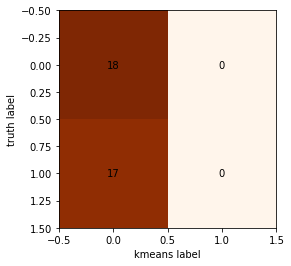

In [95]:
kmeans = KMeans(n_clusters = 2,init = 'random') #use k-means with only 2 clusters for low vs high
kmeans.fit(np.reshape(psd,(psd.shape[0],-1))) # fit centers (need to flatten into matrix)
k_labels = kmeans.labels_  # Get cluster labels
k_labels_matched = np.empty_like(k_labels)

# For each cluster label...
for k in np.unique(k_labels):
    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(labels==t)) for t in np.unique(labels)]
    k_labels_matched[k_labels==k] = np.unique(labels)[np.argmax(match_nums)]
    
cm = confusion_matrix(labels,k_labels_matched) #visualize results using confusion matrix
plt.imshow(cm,interpolation='none',cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

To visualize the results of the classification, we plotted a confusion matrix. Here's how to interpret them:
- The top left corner represents the number of datapoints correctly labeled '0' (low-load)
- The bottom left corner represents the number of datapoints incorrectly labeled as '0' (low-load). These datapoints are actually from EEG taken after a high-load working memory task but were incorrectly classified as low-load.
- The top right corner represents the number of datapoints incorrectly labeled as '1' (high-load). These datapoints are actually from EEG taken after a high-load working memory task but were incorrectly classified as low-load.
- the bottom right corner represents the number of true negatives (in this case, the number of datapoints correctly labeled '1' (high-load)

So clearly, k-means clustering did not work on this set of extracted features - the algorithm classified all the datapoints as low-load, which is incorrect.

We'll try another clustering method: Spectral Clustering. Perhaps the data does not have conventional clusters.

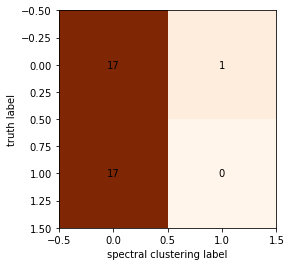

In [96]:
spectral = SpectralClustering(n_clusters=2,assign_labels='discretize') #Try spectral clustering with 2 clusters
spectral.fit(np.reshape(psd,(psd.shape[0],-1))) #find clusters

s_labels = spectral.labels_  # Get cluster labels
s_labels_matched = np.empty_like(s_labels)
for k in np.unique(s_labels):
    # ...find and assign the best-matching truth label
    match_nums = [np.sum((s_labels==k)*(labels==t)) for t in np.unique(labels)]
    k_labels_matched[s_labels==k] = np.unique(labels)[np.argmax(match_nums)]
    
cm = confusion_matrix(labels,s_labels_matched) #visualize results using confusion matrix
plt.imshow(cm,interpolation='none',cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("spectral clustering label")
plt.ylabel("truth label")
plt.show()

Spectral Clustering also appears to not work on this data. The majority of the datapoints were classified as low-load, with half of these actually being high-load. Additionally, the singular datapoint classified as from a high-load recording was in fact low-load.

We'll try to classify the data once more using logistic regression. We decided to try this because logistic regression is a supervised algorithm, and supervised algorithms tend to perform better on classification tasks because we can pass in the labels.

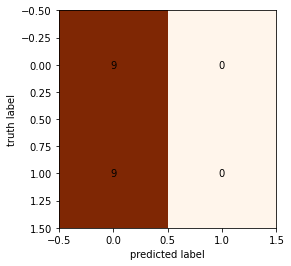

In [97]:
#split data into train and test set for supervised classification
data_train, data_test, labels_train, labels_test = train_test_split(psd,labels,test_size=0.5,random_state=None)

logistic_regression = LogisticRegression() #try basic logistic regression
logistic_regression.fit(np.reshape(data_train,(data_train.shape[0],-1)),labels_train) #train model
preds = logistic_regression.predict(np.reshape(data_test,(data_test.shape[0],-1))) #get test predictions

cm = confusion_matrix(labels_test,preds) # visualize results as confusion matirx
plt.imshow(cm,cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("predicted label")
plt.ylabel("truth label")
plt.show()

Logistic Regression did not work as well. All three of the methods we tried simply labeled all the data as low-load and completely failed the classification.

Perhaps this is an issue with how we extract our features. Because the number of epochs is variable between samples, we needed to average over the epochs so we could get a rectangular matrix to run through the classification algorithms above. It's possible that doing so obscured the nuances in the dataset. Instead, let's try extracting features from the whole dataset and see whether that improves the results.

## Classification based on timepoints of spindle annotations

This time, we'll extract the power series from the raw data rather than the epoched data.

In [73]:
raw_power_series = []
fxs = []
labels = []

for eeg_file_name in eeg_file_names:
    
    if eeg_file_name in skip:
        continue
    
    # adding our labels to the data - this will allow us to evaluate the accuracy of the clustering  
    if 'l2' in eeg_file_name:      # annotate with '0' if low-load
        labels.append(0)
    else:                          # annotate with '1' if low-load
        labels.append(1)
    
    full_eeg_path = eeg_file_dir + eeg_file_name
    
    # this time, when we import the data we want to crop it to exactly 30 minutes so we look at the same
    # amount of data for each sample
    cropped_data = import_data(full_eeg_path)
    
    # this time, when we extract the power series, we just end up with a matrix with shape
    # (num_num_channels, num_frequencies) because we aren't passing in an instance of mne.Epochs
    psds, fx = extract_power_series(cropped_data)
    raw_power_series.append(psds)  
    fxs.append(fx)
    
raw_power_series = np.array(raw_power_series)
fxs = np.array(fxs)
labels = np.array(labels)

np.savez_compressed(extracted_features_file_dir + 'extracted_features_full_data.npz',raw_psd=raw_power_series, freqs=fxs, label=labels)

Opening raw data file ./cleaned_eeg/suj11_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj11_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1858749 =      0.000 ...  1858.749 secs
Ready.
Reading 0 ... 1858749  =      0.000 ...  1858.749 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj11_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj11_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806049 =      0.000 ...  1806.049 secs
Ready.
Reading 0 ... 1806049  =      0.000 ...  1806.049 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj12_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj12_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1810549 =      0.000 ...  1810.549 secs
Ready.
Reading 0 ... 1810549  =      0.000 ...  1810.549 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj12_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj12_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806899 =      0.000 ...  1806.899 secs
Ready.
Reading 0 ... 1806899  =      0.000 ...  1806.899 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj13_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj13_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802149 =      0.000 ...  1802.149 secs
Ready.
Reading 0 ... 1802149  =      0.000 ...  1802.149 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj13_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj13_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805099 =      0.000 ...  1805.099 secs
Ready.
Reading 0 ... 1805099  =      0.000 ...  1805.099 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj14_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj14_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803449 =      0.000 ...  1803.449 secs
Ready.
Reading 0 ... 1803449  =      0.000 ...  1803.449 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj15_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj15_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802649 =      0.000 ...  1802.649 secs
Ready.
Reading 0 ... 1802649  =      0.000 ...  1802.649 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/Suj15_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/Suj15_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805349 =      0.000 ...  1805.349 secs
Ready.
Reading 0 ... 1805349  =      0.000 ...  1805.349 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj16_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj16_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805999 =      0.000 ...  1805.999 secs
Ready.
Reading 0 ... 1805999  =      0.000 ...  1805.999 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj16_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj16_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806399 =      0.000 ...  1806.399 secs
Ready.
Reading 0 ... 1806399  =      0.000 ...  1806.399 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj17_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj17_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804949 =      0.000 ...  1804.949 secs
Ready.
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj17_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj17_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1811799 =      0.000 ...  1811.799 secs
Ready.
Reading 0 ... 1811799  =      0.000 ...  1811.799 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj18_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj18_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803199 =      0.000 ...  1803.199 secs
Ready.
Reading 0 ... 1803199  =      0.000 ...  1803.199 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj18_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj18_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805399 =      0.000 ...  1805.399 secs
Ready.
Reading 0 ... 1805399  =      0.000 ...  1805.399 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj19_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj19_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1806249 =      0.000 ...  1806.249 secs
Ready.
Reading 0 ... 1806249  =      0.000 ...  1806.249 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj19_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj19_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1802649 =      0.000 ...  1802.649 secs
Ready.
Reading 0 ... 1802649  =      0.000 ...  1802.649 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj20_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj20_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1825449 =      0.000 ...  1825.449 secs
Ready.
Reading 0 ... 1825449  =      0.000 ...  1825.449 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj20_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj20_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807249 =      0.000 ...  1807.249 secs
Ready.
Reading 0 ... 1807249  =      0.000 ...  1807.249 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj21_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj21_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1816949 =      0.000 ...  1816.949 secs
Ready.
Reading 0 ... 1816949  =      0.000 ...  1816.949 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj21_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj21_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803149 =      0.000 ...  1803.149 secs
Ready.
Reading 0 ... 1803149  =      0.000 ...  1803.149 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj22_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj22_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1805499 =      0.000 ...  1805.499 secs
Ready.
Reading 0 ... 1805499  =      0.000 ...  1805.499 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj22_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj22_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1808649 =      0.000 ...  1808.649 secs
Ready.
Reading 0 ... 1808649  =      0.000 ...  1808.649 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj23_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj23_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804149 =      0.000 ...  1804.149 secs
Ready.
Reading 0 ... 1804149  =      0.000 ...  1804.149 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj23_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj23_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807699 =      0.000 ...  1807.699 secs
Ready.
Reading 0 ... 1807699  =      0.000 ...  1807.699 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj25_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj25_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1827349 =      0.000 ...  1827.349 secs
Ready.
Reading 0 ... 1827349  =      0.000 ...  1827.349 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj26_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj26_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804649 =      0.000 ...  1804.649 secs
Ready.
Reading 0 ... 1804649  =      0.000 ...  1804.649 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj26_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj26_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1830449 =      0.000 ...  1830.449 secs
Ready.
Reading 0 ... 1830449  =      0.000 ...  1830.449 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj27_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj27_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804549 =      0.000 ...  1804.549 secs
Ready.
Reading 0 ... 1804549  =      0.000 ...  1804.549 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj28_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj28_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1807649 =      0.000 ...  1807.649 secs
Ready.
Reading 0 ... 1807649  =      0.000 ...  1807.649 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj28_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj28_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1811849 =      0.000 ...  1811.849 secs
Ready.
Reading 0 ... 1811849  =      0.000 ...  1811.849 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj29_l5nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj29_l5nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1804949 =      0.000 ...  1804.949 secs
Ready.
Reading 0 ... 1804949  =      0.000 ...  1804.949 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj29_l2nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj29_l2nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803799 =      0.000 ...  1803.799 secs
Ready.
Reading 0 ... 1803799  =      0.000 ...  1803.799 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj32_l2nap_day1.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj32_l2nap_day1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1803899 =      0.000 ...  1803.899 secs
Ready.
Reading 0 ... 1803899  =      0.000 ...  1803.899 secs...
Effective window size : 1.000 (s)
Opening raw data file ./cleaned_eeg/suj32_l5nap_day2.fif...


/var/folders/df/k_z85q4d1570xsykvqmx0l4r0000gn/T/ipykernel_74624/451345161.py:4: RuntimeWarning: This filename (./cleaned_eeg/suj32_l5nap_day2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(eeg_file, preload=True)


    Range : 0 ... 1830049 =      0.000 ...  1830.049 secs
Ready.
Reading 0 ... 1830049  =      0.000 ...  1830.049 secs...
Effective window size : 1.000 (s)


Let's try once more to cluster the data using the same three methods as before.

In [100]:
data = np.load('./extracted_features/extracted_features_full_data.npz')
psd = data['raw_psd']
labels = data['label']

First, we'll try k-means clustering.

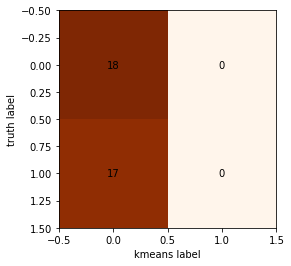

In [101]:
kmeans = KMeans(n_clusters = 2,init = 'random') #use k-means with only 2 clusters for low vs high
kmeans.fit(np.reshape(psd,(psd.shape[0],-1))) # fit centers (need to flatten into matrix)
k_labels = kmeans.labels_  # Get cluster labels
k_labels_matched = np.empty_like(k_labels)

# For each cluster label...
for k in np.unique(k_labels):
    # ...find and assign the best-matching truth label
    match_nums = [np.sum((k_labels==k)*(labels==t)) for t in np.unique(labels)]
    k_labels_matched[k_labels==k] = np.unique(labels)[np.argmax(match_nums)]
    
cm = confusion_matrix(labels,k_labels_matched) #visualize results using confusion matrix
plt.imshow(cm,interpolation='none',cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("kmeans label")
plt.ylabel("truth label")
plt.show()

K-means clustering still appears to not work for this dataset. Like before, all the datapoints are being classified as low-load, with half of those classifications being incorrect.

Let's run this data through Spectral Clustering.

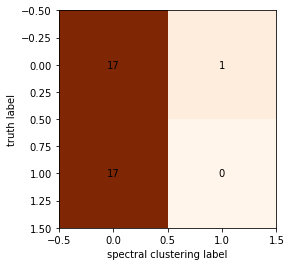

In [102]:
spectral = SpectralClustering(n_clusters=2,assign_labels='discretize') #Try spectral clustering with 2 clusters
spectral.fit(np.reshape(psd,(psd.shape[0],-1))) #find clusters

s_labels = spectral.labels_  # Get cluster labels
s_labels_matched = np.empty_like(s_labels)
for k in np.unique(s_labels):
    # ...find and assign the best-matching truth label
    match_nums = [np.sum((s_labels==k)*(labels==t)) for t in np.unique(labels)]
    k_labels_matched[s_labels==k] = np.unique(labels)[np.argmax(match_nums)]
    
cm = confusion_matrix(labels,s_labels_matched) #visualize results using confusion matrix
plt.imshow(cm,interpolation='none',cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("spectral clustering label")
plt.ylabel("truth label")
plt.show()

This attempt also failed. The results are the same as our attempt with the epoched data.

We'll try logistic regression as well.

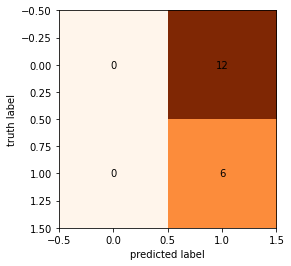

In [103]:
#split data into train and test set for supervised classification
data_train, data_test, labels_train, labels_test = train_test_split(psd,labels,test_size=0.5,random_state=None)

logistic_regression = LogisticRegression() #try basic logistic regression
logistic_regression.fit(np.reshape(data_train,(data_train.shape[0],-1)),labels_train) #train model
preds = logistic_regression.predict(np.reshape(data_test,(data_test.shape[0],-1))) #get test predictions

cm = confusion_matrix(labels_test,preds) # visualize results as confusion matirx
plt.imshow(cm,cmap='Oranges')
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("predicted label")
plt.ylabel("truth label")
plt.show()

Interestingly, the algorithm this time classified everything as high-load rather than low-load. However, like before, a majority of these classifications is incorrect. It appears that classifying this data according to the completion of a low-load or high-load working memory task is more complex than is feasible.

# Conclusion & Discussion

As demonstrated by this exploratory analysis, it doesn't appear possible to differentiate between sleep after a low load working memory task and sleep after a high load working memory task using simple clustering and classification algorithms.

However, there are many limitations to our analysis. The main issue is that our dataset is very small. This means that any algorithm we run has a high tendency to overfit our data and confound the results. To better test our question, we would need to run many more classification and clustering algorithms on the data, which would take much more time than we have.

Another limitation of our analysis is that we only extracted the power series from the data. If we had the time to be more thorough, we would have attemped to extract the power series using multiple tools. We also would have extracted more features. We chose not to extract more features due to the time constraint. We were also unclear on how to create a rectangular matrix when the features would likely all be different dimensions.

In the future, we would like to expland this analysis and try out more classification algorithms. We would also like to retreive working memory EEG data and normal sleep EEG data and investigate the similarities and differences between those and the Nap EEG dataset we utilized here.